In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split, KFold
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from tqdm.auto import trange, tqdm
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from scipy.stats import pearsonr

In [2]:
#import dataset
creep_df = pd.read_csv('../Data/Ti_alloys_dataset.csv')
creep_df

,Ti,Al,V,Fe,C,N,H,O,Sn,Nb,...,Cr,Solution treated temp(cel),ST time (h),Anneal temp (cel),Annealing Time (hour),Temperature of creep test (cel),Stress (Mpa),steady state strain rate (1/s),Strain to rupture (%) (Efc),creep_rupture_life
0,87.8750,6.75,4.50,0.40,0.100,0.050,0.1250,0.20,0.00,0.0,...,0.0,690,4.0,1050,0.5,700,319.0,2.090000e-03,15.80,0.01000
1,87.8100,6.61,4.23,1.18,0.026,0.011,0.0030,0.13,0.00,0.0,...,0.0,0,0.0,0,0.0,600,319.0,3.240000e-06,0.00,0.01167
2,87.8100,6.61,4.23,1.18,0.026,0.011,0.0030,0.13,0.00,0.0,...,0.0,0,0.0,0,0.0,600,250.0,4.400000e-05,0.00,0.03050
3,87.8100,6.61,4.23,1.18,0.026,0.011,0.0030,0.13,0.00,0.0,...,0.0,0,0.0,0,0.0,500,520.0,4.430000e-05,0.00,0.04620
4,87.8100,6.61,4.23,1.18,0.026,0.011,0.0030,0.13,0.00,0.0,...,0.0,0,0.0,0,0.0,700,319.0,2.130000e-03,0.00,0.05000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,85.9870,6.20,0.00,0.00,0.021,0.004,0.0080,0.03,1.95,0.0,...,0.0,900,1.0,580,8.0,520,310.0,1.200000e-04,0.00,1160.00000
173,89.0434,6.51,4.08,0.16,0.010,0.005,0.0016,0.19,0.00,0.0,...,0.0,0,0.0,940,4.0,455,379.0,9.160000e-07,0.00,1619.00000
174,89.0434,6.51,4.08,0.16,0.010,0.005,0.0016,0.19,0.00,0.0,...,0.0,0,0.0,1030,0.5,455,379.0,1.270000e-06,0.00,1744.00000
175,89.4100,6.00,4.00,0.25,0.080,0.050,0.0100,0.20,0.00,0.0,...,0.0,0,0.0,0,0.0,538,103.0,9.000000e-07,22.30,4681.00000


In [3]:
creep_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Ti                               177 non-null    float64
 1   Al                               177 non-null    float64
 2   V                                177 non-null    float64
 3   Fe                               177 non-null    float64
 4   C                                177 non-null    float64
 5   N                                177 non-null    float64
 6   H                                177 non-null    float64
 7   O                                177 non-null    float64
 8   Sn                               177 non-null    float64
 9   Nb                               177 non-null    float64
 10  Mo                               177 non-null    float64
 11  Zr                               177 non-null    float64
 12  Si                    

In [4]:
features = creep_df.iloc[:, 0:23]
targets = np.log10(creep_df.iloc[:, 23])
features

,Ti,Al,V,Fe,C,N,H,O,Sn,Nb,...,B,Cr,Solution treated temp(cel),ST time (h),Anneal temp (cel),Annealing Time (hour),Temperature of creep test (cel),Stress (Mpa),steady state strain rate (1/s),Strain to rupture (%) (Efc)
0,87.8750,6.75,4.50,0.40,0.100,0.050,0.1250,0.20,0.00,0.0,...,0.00,0.0,690,4.0,1050,0.5,700,319.0,2.090000e-03,15.80
1,87.8100,6.61,4.23,1.18,0.026,0.011,0.0030,0.13,0.00,0.0,...,0.00,0.0,0,0.0,0,0.0,600,319.0,3.240000e-06,0.00
2,87.8100,6.61,4.23,1.18,0.026,0.011,0.0030,0.13,0.00,0.0,...,0.00,0.0,0,0.0,0,0.0,600,250.0,4.400000e-05,0.00
3,87.8100,6.61,4.23,1.18,0.026,0.011,0.0030,0.13,0.00,0.0,...,0.00,0.0,0,0.0,0,0.0,500,520.0,4.430000e-05,0.00
4,87.8100,6.61,4.23,1.18,0.026,0.011,0.0030,0.13,0.00,0.0,...,0.00,0.0,0,0.0,0,0.0,700,319.0,2.130000e-03,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,85.9870,6.20,0.00,0.00,0.021,0.004,0.0080,0.03,1.95,0.0,...,0.00,0.0,900,1.0,580,8.0,520,310.0,1.200000e-04,0.00
173,89.0434,6.51,4.08,0.16,0.010,0.005,0.0016,0.19,0.00,0.0,...,0.00,0.0,0,0.0,940,4.0,455,379.0,9.160000e-07,0.00
174,89.0434,6.51,4.08,0.16,0.010,0.005,0.0016,0.19,0.00,0.0,...,0.00,0.0,0,0.0,1030,0.5,455,379.0,1.270000e-06,0.00
175,89.4100,6.00,4.00,0.25,0.080,0.050,0.0100,0.20,0.00,0.0,...,0.00,0.0,0,0.0,0,0.0,538,103.0,9.000000e-07,22.30


In [5]:
class MyDataset(Dataset):
    def __init__(self, data, targets):
        self.features = data
        self.labels = targets

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]

        return feature, label

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Run #  1 Fold # 1
Pearson CC: 0.9625636746105973
R2 score: 0.9025060602180699
RMSE: 0.31975242495536804
MAE: 0.21392236649990082
Coverage: 80.55555555555553
Interval Width: 0.7051088213920593
Composite Metric: 0.9587218678148213


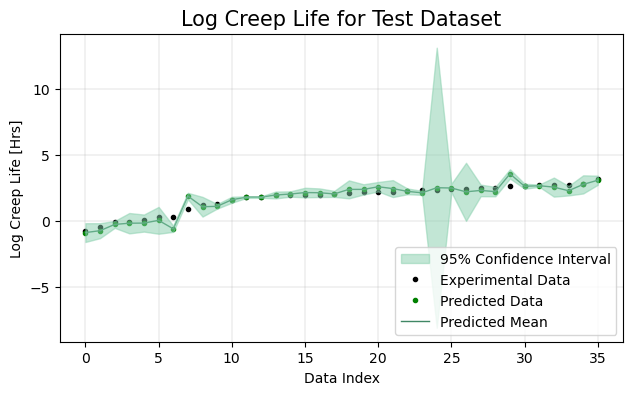

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Run #  1 Fold # 2
Pearson CC: 0.6944865691265804
R2 score: 0.40686308347151834
RMSE: 1.0378601551055908
MAE: 0.5407571792602539
Coverage: 69.44444444444443
Interval Width: 0.9204529523849487
Composite Metric: 0.7924387416839014


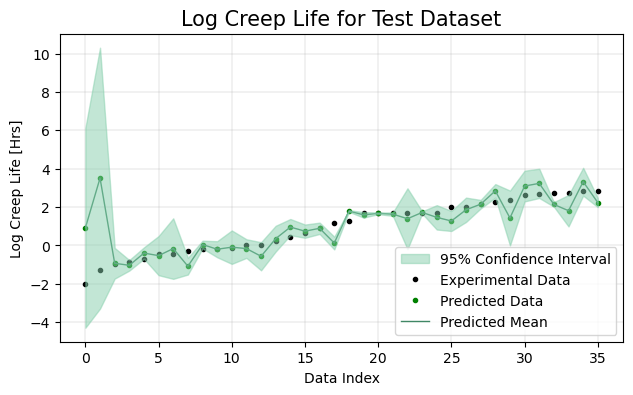

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Run #  1 Fold # 3
Pearson CC: 0.9405578113859483
R2 score: 0.8796346790962991
RMSE: 0.4342312216758728
MAE: 0.313544899225235
Coverage: 77.14285714285715
Interval Width: 0.9061871767044067
Composite Metric: 0.8544526222440121


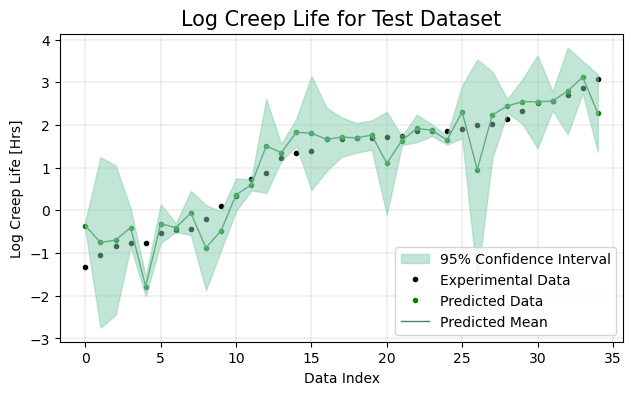

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Run #  1 Fold # 4
Pearson CC: 0.9403901667506273
R2 score: 0.8809286273006943
RMSE: 0.42332613468170166
MAE: 0.2999071478843689
Coverage: 71.42857142857144
Interval Width: 0.49703502655029297
Composite Metric: 1.0386969461821864


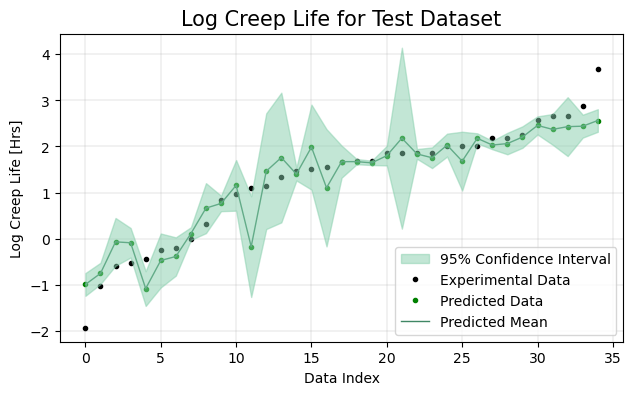

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Run #  1 Fold # 5
Pearson CC: 0.8291261932398238
R2 score: 0.6857726631869188
RMSE: 0.5717711448669434
MAE: 0.4190460443496704
Coverage: 71.42857142857143
Interval Width: 0.749474287033081
Composite Metric: 0.8692814331472773


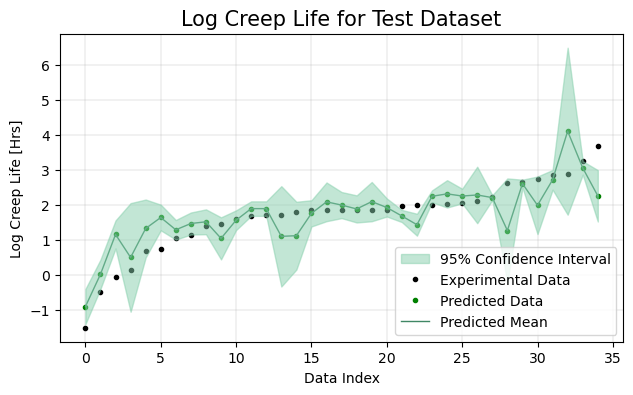

In [6]:
# Evaluate multiple runs of the model
nruns = 1
nfolds = 5

# Metrics for performance evaluation
PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)

test_coverage = np.zeros_like(PearsonCC)
median_interval_width = np.zeros_like(PearsonCC)
composite_metric = np.zeros_like(PearsonCC)

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            x_train, x_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            # normalized features to the [0,1] range
            scaler = MinMaxScaler()
            x_train = scaler.fit_transform(x_train)
            x_test = scaler.transform(x_test)

            x_train = x_train.astype(dtype=np.float32)
            x_test = x_test.astype(np.float32)
            y_train_np = y_train.to_numpy(dtype=np.float32)
            y_test_np =  y_test.to_numpy(dtype=np.float32)

            x_train = torch.from_numpy(x_train)
            y_train = torch.from_numpy(y_train_np)

            x_test = torch.from_numpy(x_test)
            y_test = torch.from_numpy(y_test_np)

            train_dataset = MyDataset(x_train, y_train)
            train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=32)

            # define DNN
            class MLP(nn.Module):
                  def __init__(self, input_dim=23, output_dim=1, hidden_dim=100, n_hidden_layers=1, use_dropout=False):
                        super().__init__()

                        self.use_dropout = use_dropout
                        if use_dropout:
                              self.dropout = nn.Dropout(p=0.5)
                        self.activation = nn.ReLU()

                        # dynamically define architecture
                        self.layer_sizes = [input_dim] + n_hidden_layers * [hidden_dim] + [output_dim]
                        layer_list = [nn.Linear(self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                                    range(1, len(self.layer_sizes))]
                        self.layers = nn.ModuleList(layer_list)

                  def forward(self, input):
                        hidden = self.activation(self.layers[0](input))
                        for layer in self.layers[1:-1]:
                              hidden_temp = self.activation(layer(hidden))

                              if self.use_dropout:
                                    hidden_temp = self.dropout(hidden_temp)

                              hidden = hidden_temp + hidden  # residual connection

                        output_mean = self.layers[-1](hidden).squeeze()
                        return output_mean

            def train(net, train_dataloader):
                  optimizer = torch.optim.Adam(params=net.parameters(), lr=0.01)
                  criterion = nn.MSELoss()

                  progress_bar = trange(3000)
                  for _ in progress_bar:
                        for i, data in enumerate(train_dataloader):
                              traning_data, training_label = data
                              optimizer.zero_grad()
                              y_pred = net(torch.Tensor(traning_data))
                              loss = criterion(y_pred.squeeze(), torch.Tensor(training_label))
                              progress_bar.set_postfix(loss=f'{loss / features.shape[0]:.3f}')
                              loss.backward()
                              optimizer.step()
                  return net

            # training
            ensemble_size = 5
            ensemble = [MLP(hidden_dim=10, n_hidden_layers=3) for _ in range(ensemble_size)]

            for net in ensemble:
                  train(net, train_dataloader)

            print("Run # ", j+1, "Fold #", i+1)

            # inference
            y_preds = [np.array(net(torch.Tensor(x_test)).clone().detach().numpy()) for net in ensemble]
            # mean and standard deviation
            y_pred = np.mean(np.array(y_preds), axis=0)
            y_std = np.std(np.array(y_preds), axis=0)

            ## Metrics for evaluating the predictive accuracy of the model
            PearsonCC[j, i] = pearsonr(np.squeeze(y_test), np.squeeze(y_pred))[0]
            R2_score[j, i] = r2_score(y_test, y_pred)
            RMSE[j, i] = np.sqrt(mean_squared_error(y_pred, y_test))
            MAE[j, i] = np.mean(abs(y_pred-np.array(y_test)))

            PearsonCC[j, i] = pearsonr(np.squeeze(y_test), np.squeeze(y_pred))[0]
            R2_score[j, i] = r2_score(y_test, y_pred)
            RMSE[j, i] = np.sqrt(mean_squared_error(y_pred, y_test))
            MAE[j, i] = np.mean(abs(y_pred-np.array(y_test)))

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {RMSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')

            ## Metrics for evaluating the uncertainty quantification of the model
            # Coverage
            def coverage(y, yL, yH):
                  return np.sum(100 / y.shape[0] * ((y>yL)&(y<yH)))

            df_test_low = y_pred - 2*y_std
            df_test_mean = y_pred
            df_test_high = y_pred + 2*y_std

            test_coverage[j, i] = coverage(y_test_np, df_test_low, df_test_high)
            print(f'Coverage: {test_coverage[j, i]}')
 
            # Prediction interval width
            # Quantifies the average width of the prediction intervals. Smaller widths suggest more precise uncertainty estimates.
            median_interval_width[j, i] = np.median(df_test_high - df_test_low)
            print(f'Interval Width: {median_interval_width[j, i]}')

            # Composite metric that combines the coverage and the invers of interval width
            composite_metric[j, i] = 0.75*test_coverage[j, i]/100 + 0.25*(1/median_interval_width[j, i])
            print(f'Composite Metric: {composite_metric[j, i]}')

            # Plot the predictions
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
            iteration_list = [i for i in range(len(y_test))]

            ## Uncertainty quantification plot
            ax[0].fill_between(iteration_list, y_pred - 2*y_std, y_pred + 2*y_std, alpha=0.5, color='#86cfac', zorder=5, label='95% Confidence Interval')
            ax[0].plot(iteration_list, y_test_np, 'ko', markersize=3, label="Experimental Data")
            ax[0].plot(iteration_list, y_pred, 'go', markersize=3, label="Predicted Data")
            ax[0].plot(iteration_list, y_pred, '-', linewidth=1, color="#408765", label="Predicted Mean")
            ax[0].legend(loc=4, fontsize=10, frameon=True)
            ax[0].set_xlabel("Data Index", fontsize=10)
            ax[0].set_ylabel("Log Creep Life [Hrs]", fontsize=10)
            ax[0].set_title("Log Creep Life for Test Dataset", fontsize=15)
            ax[0].grid(True, which='major', linestyle='-', linewidth='0.25')
            fig.delaxes(ax[1])

            plt.show()

In [7]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE
0,0.962564,0.902506,0.319752,0.213922
1,0.694487,0.406863,1.037860,0.540757
2,0.940558,0.879635,0.434231,0.313545
3,0.940390,0.880929,0.423326,0.299907
4,0.829126,0.685773,0.571771,0.419046


In [8]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   'RMSE Std': RMSE_std},index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std
0,0.873425,0.100914,0.751141,0.189244,0.557388,0.253247,0.357436,0.112459


In [9]:
# Data frame
df3 = pd.DataFrame({'Coverage': test_coverage.flatten(),  'Interval Width': median_interval_width.flatten(), 'Composite Metric': composite_metric.flatten()},index=None)
df3

,Coverage,Interval Width,Composite Metric
0,80.555556,0.705109,0.958722
1,69.444444,0.920453,0.792439
2,77.142857,0.906187,0.854453
3,71.428571,0.497035,1.038697
4,71.428571,0.749474,0.869281


In [10]:
# Calculate mean values and standard deviations of the scores
test_coverage_mean = np.mean(test_coverage)
median_interval_width_mean = np.mean(median_interval_width)
composite_metric_mean = np.mean(composite_metric)

test_coverage_std = np.std(test_coverage)
median_interval_width_std = np.std(median_interval_width)
composite_metric_std = np.std(composite_metric)

# Data frame
df4 = pd.DataFrame({'Coverage Mean': test_coverage_mean, 'Coverage Std': test_coverage_std, 
                    'Interval Width Mean': median_interval_width_mean, 'Interval Width Std':median_interval_width_std,
                   'Composite Metric Mean': composite_metric_mean, 'Composite Metric Std': composite_metric_std,},index=[0])
df4

,Coverage Mean,Coverage Std,Interval Width Mean,Interval Width Std,Composite Metric Mean,Composite Metric Std
0,74.0,4.167264,0.755652,0.154464,0.902718,0.086297
